## March Madness Logistic Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('NCAA_Tourney_2002-2016.csv')

In [4]:
mm_data.columns

Index([u'Numot', u'Season', u'game_id', u'host_lat', u'host_long',
       u'host_site', u'season', u'team1_id', u'team1_score', u'team2_id',
       u'team2_score', u'team1_seed', u'team1_lat', u'team1_long',
       u'team1_teamname', u'team1_fg2pct', u'team1_fg3pct', u'team1_ftpct',
       u'team1_blockpct', u'team1_oppfg2pct', u'team1_oppfg3pct',
       u'team1_oppftpct', u'team1_oppblockpct', u'team1_f3grate',
       u'team1_oppf3grate', u'team1_arate', u'team1_opparate',
       u'team1_stlrate', u'team1_oppstlrate', u'team1_tempo',
       u'team1_adjtempo', u'team1_oe', u'team1_adjoe', u'team1_de',
       u'team1_adjde', u'team1_ap_preseason', u'team1_ap_final',
       u'team1_coaches_preseason', u'team1_coaches_before_final',
       u'team1_rpi_rating', u'team1_coach_id', u'team1_coach_name',
       u'team1_pt_school_ncaa', u'team1_pt_overall_ncaa',
       u'team1_pt_school_s16', u'team1_pt_overall_s16', u'team1_pt_school_ff',
       u'team1_pt_overall_ff', u'team1_pt_career_school

In [5]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [7]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

## Pythag College Basketball
E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [8]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

## Log 5
P(W) = (A - A * B) / (A + B - 2*A*B)

In [9]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [10]:
mm_data[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head()

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,111.4954,Alabama,2002,Florida Atlantic,93.8770,0.878465,0.411542,0.911780
1,117.3877,Arizona,2002,UC Santa Barbara,96.9262,0.900485,0.707177,0.789333
2,109.6136,Indiana,2002,Utah,89.9224,0.906968,0.812015,0.692962
3,115.0406,Kansas,2002,Holy Cross,90.5399,0.940149,0.501475,0.939816
4,113.6686,Kent St.,2002,Oklahoma St.,96.2010,0.871998,0.809638,0.615641


## Seed Diff

In [11]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [12]:
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id
0,2002-1104-1194,0.878465,0.411542,78,86,-88.820532,0.911780,1104,1194
1,2002-1112-1364,0.900485,0.707177,81,86,-697.542289,0.789333,1112,1364
2,2002-1231-1428,0.906968,0.812015,56,75,2148.977013,0.692962,1231,1428
3,2002-1242-1221,0.940149,0.501475,59,70,-39.535171,0.939816,1242,1221
4,2002-1245-1329,0.871998,0.809638,61,69,-1066.404958,0.615641,1245,1329


## Split Data

In [13]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [14]:
mm_data['team1_win'] = mm_data['result']

In [15]:
def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)
my_randoms = random.sample(xrange(len(mm_data)), len(mm_data)/2)
mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2015)].shape

(34, 108)

In [16]:
mm_data = shuffle(mm_data)

In [17]:
my_randoms = random.sample(xrange(len(mm_data)), len(mm_data)/2)

In [18]:
mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2015)].shape

(37, 108)

In [19]:
mm_data_1 = mm_data[~mm_data.index.isin(my_randoms)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                                      'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']].reset_index(drop=True)
mm_data_2 = mm_data[mm_data.index.isin(my_randoms)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']].reset_index(drop=True)

In [23]:
mm_data_2['team1_win'] = mm_data_2['team1_win'].apply(lambda x: 1 if x==0 else 0)
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data['seed_diff'] = mm_data['seed_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff']

In [24]:
mm_train = pd.concat([mm_data_2, mm_data_1])

In [54]:
mm_data_2016 = mm_train[mm_train['season'] == 2016].reset_index(drop=True)
mm_data_else =  mm_train[mm_train['season'] <> 2016].reset_index(drop=True)

## Initial Check

In [55]:
mm_data_else.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.379062
1    0.622609
Name: team1_log5, dtype: float64

In [56]:
mm_data_else.groupby('team1_win')['seed_diff'].mean()

team1_win
0   -0.016949
1   -0.104784
Name: seed_diff, dtype: float64

In [57]:
mm_data_else.groupby('team1_win')['diff_dist'].mean()

team1_win
0    187.924021
1   -123.308322
Name: diff_dist, dtype: float64

## Train Logit

In [58]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [59]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else['team1_log5']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.675154
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  911
Model:                          Logit   Df Residuals:                      910
Method:                           MLE   Df Model:                            0
Date:                Tue, 07 Feb 2017   Pseudo R-squ.:                 0.02504
Time:                        14:31:18   Log-Likelihood:                -615.07
converged:                       True   LL-Null:                       -630.86
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
team1_log5     0.7015      0.124      5.641      0.000         0.458     0.945
==============================================================================
"""

In [60]:
mm_data_2016['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2016[['team1_log5']]))[:,1]
mm_data_2016['prediction'] = logit.predict(scaler.fit_transform(mm_data_2016[['team1_log5']]))

In [61]:
mm_data_2016[['team1_log5','team1_win','preds','prediction']].head()

,team1_log5,team1_win,preds,prediction
0,0.556931,1,0.503910,1
1,0.323553,0,0.203026,0
2,0.310680,0,0.190960,0
3,0.947323,1,0.911277,1
4,0.683007,1,0.681970,1


In [62]:
mm_data_2016.groupby('team1_win')['preds'].mean()

team1_win
0    0.333227
1    0.606736
Name: preds, dtype: float64

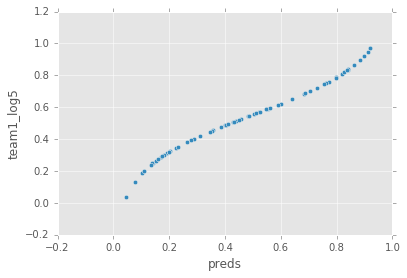

In [63]:
mm_data_2016.plot(kind='scatter', x='preds',y='team1_log5')

In [64]:
confusion_matrix(mm_data_2016['team1_win'], mm_data_2016['prediction'])

array([[24,  7],
       [12, 24]])

In [65]:
accuracy_score(mm_data_2016['team1_win'], mm_data_2016['prediction'],)

0.71641791044776115

In [66]:
precision_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.77419354838709675

In [67]:
recall_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.66666666666666663

In [68]:
f1_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.71641791044776115

In [69]:
log_loss(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.54855188374610131

In [70]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

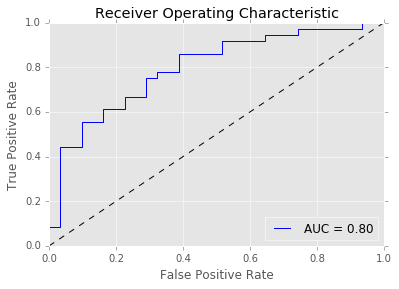

In [71]:
fpr, tpr, thresholds = roc_curve(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [72]:
roc_auc_score(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.79749103942652333

## Add Seed Difference & Distance

In [73]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5','diff_dist','seed_diff']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [74]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else[['team1_log5','diff_dist','seed_diff']]).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.666556
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  911
Model:                          Logit   Df Residuals:                      908
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Feb 2017   Pseudo R-squ.:                 0.03745
Time:                        14:31:28   Log-Likelihood:                -607.23
converged:                       True   LL-Null:                       -630.86
                                        LLR p-value:                 5.483e-11
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
team1_log5     0.6938      0.126      5.518      0.000         0.447     0.940
diff_dist     -0.0002   6.04e-05     -3.892      0.000        -0.000    -0.000
seed_diff     -0.0013      0.009     -0.139      0.890        -0.019     0.017
==============================================================================
"""

In [75]:
mm_data_2016['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2016[['team1_log5','diff_dist','seed_diff']]))[:,1]
mm_data_2016['prediction'] = logit.predict(scaler.fit_transform(mm_data_2016[['team1_log5','diff_dist','seed_diff']]))

In [76]:
accuracy_score(mm_data_2016['team1_win'], mm_data_2016['prediction'],)

0.68656716417910446

In [77]:
precision_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.74193548387096775

In [78]:
recall_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.63888888888888884

In [79]:
f1_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.68656716417910446

In [80]:
log_loss(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.54162423806937987

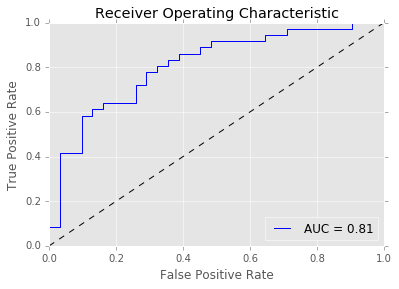

In [81]:
fpr, tpr, thresholds = roc_curve(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [82]:
roc_auc_score(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.80913978494623651